In [10]:
import gymnasium as gym
import numpy as np
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import heapq
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import imageio

# Create FrozenLake environment
environment = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array", desc=generate_random_map(8))

# Get environment information
n_states = environment.observation_space.n
n_actions = environment.action_space.n
grid_size = int(np.sqrt(n_states))  # Assuming a square grid

# Define possible actions (0: left, 1: down, 2: right, 3: up)
actions = {
    0: (0, -1),  # Left
    1: (1, 0),   # Down
    2: (0, 1),   # Right
    3: (-1, 0)   # Up
}

## BnB

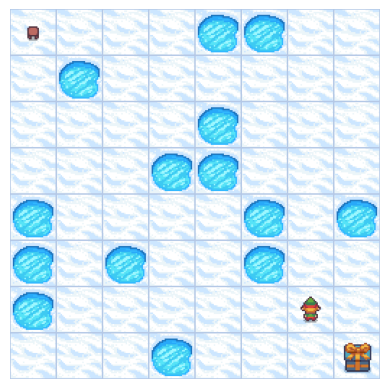

 Path found by Branch and Bound: [0, 1, 2, 3, 11, 12, 13, 14, 22, 30, 38, 46, 47, 55, 63]


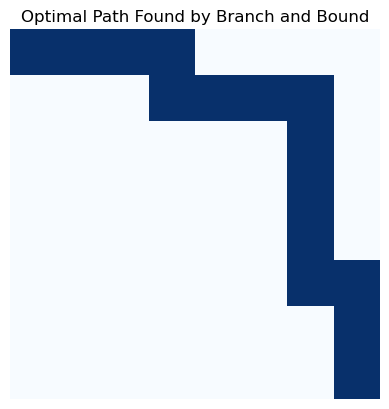

 GIF saved as frozenlake_branch_bound.gif


In [11]:
# Helper functions
def state_to_coord(state):
    """
    Converts a 1D state index into a 2D coordinate (row, column) based on the grid size.

    Parameters:
    state (int): The state index in a flattened 1D representation of a 2D grid.

    Returns:
    tuple: A tuple (row, col) representing the coordinates in the 2D grid.

    Note:
    Assumes a global variable `grid_size` which defines the number of columns in the grid.
    """
    return (state // grid_size, state % grid_size)



def coord_to_state(coord):
    """
    Converts a 2D coordinate (row, column) into a 1D state index based on the grid size.

    Parameters:
    coord (tuple): A tuple (row, col) representing the position in the 2D grid.

    Returns:
    int: The corresponding state index in the flattened 1D representation of the grid.

    Note:
    Assumes a global variable `grid_size` which defines the number of columns in the grid.
    """
    return coord[0] * grid_size + coord[1]


frames = []  # To store frames for GIF

def render_env(environment, delay=0.3, collect_frames=False):
    """
    Renders the current state of the environment and optionally collects frames for creating a GIF.

    Parameters:
    environment (gym.Env): The environment to render.
    delay (float): Time to wait (in seconds) between frames. Default is 0.3.
    collect_frames (bool): Whether to store each rendered frame for GIF creation. Default is False.

    Side Effects:
    - Displays the environment visually using matplotlib.
    - Stores frames in the global `frames` list if `collect_frames` is True.
    - Uses `time.sleep` for visual delay and `clear_output` for smooth updates in Jupyter notebooks.
    """
    clear_output(wait=True)
    frame = environment.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    if collect_frames:
        frames.append(np.array(frame))
    time.sleep(delay)


def branch_and_bound(environment, start_state, goal_state):
    """
    Executes the Branch and Bound algorithm to find the shortest path from the start to the goal in a grid-based environment.

    Parameters:
    environment (gym.Env): The environment representing the search space.
    start_state (int): The starting state's 1D index.
    goal_state (int): The goal state's 1D index.

    Returns:
    list or None: A list of state indices representing the optimal path from start to goal if found, otherwise None.

    Note:
    - Utilizes a priority queue (heap) to explore the most promising paths first based on path cost.
    - Resets the environment for each action to ensure accurate simulation.
    - Renders each step visually and collects frames for a GIF.
    - Relies on global `actions`, `grid_size`, and `frames`.
    """
    open_list = []
    heapq.heappush(open_list, (0, start_state, [start_state]))
    g_score = {start_state: 0}
    visited = set()

    while open_list:
        curr_g, current_state, path = heapq.heappop(open_list)
        if current_state == goal_state:
            return path
        visited.add(current_state)

        for action in actions:
            dx, dy = actions[action]
            x, y = state_to_coord(current_state)
            nx, ny = x + dx, y + dy

            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbor_state = coord_to_state((nx, ny))
                environment.reset()
                environment.unwrapped.s = current_state
                new_state, reward, done, _, _ = environment.step(action)

                print(f"\n Taking action {action} from state {current_state}...")
                render_env(environment, collect_frames=True)

                if reward == 0 and done:
                    continue

                tentative_g_score = curr_g + 1
                if neighbor_state not in g_score or tentative_g_score < g_score[neighbor_state]:
                    g_score[neighbor_state] = tentative_g_score
                    heapq.heappush(open_list, (tentative_g_score, neighbor_state, path + [neighbor_state]))

    return None


# Run the algorithm
start_state, _ = environment.reset()
goal_state = n_states - 1
path = branch_and_bound(environment, start_state, goal_state)

# Plot the final path
if path:
    print(" Path found by Branch and Bound:", path)
    grid = np.zeros((grid_size, grid_size))
    for state in path:
        x, y = state_to_coord(state)
        grid[x, y] = 2

    plt.imshow(grid, cmap='Blues')
    plt.title("Optimal Path Found by Branch and Bound")
    plt.axis("off")
    plt.show()

    # Save the GIF
    gif_filename = "frozenlake_branch_bound.gif"
    imageio.mimsave(gif_filename, frames, fps=2)
    print(f" GIF saved as {gif_filename}")
else:
    print(" No path found.")


## A*

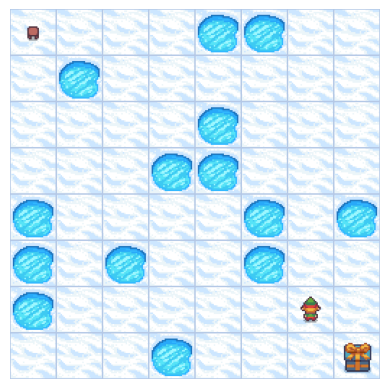

 Path found by A*: [0, 1, 2, 3, 11, 12, 13, 14, 22, 30, 38, 46, 47, 55, 63]


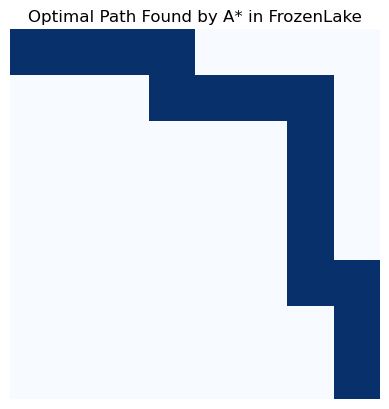

In [ ]:
# Helper functions
def state_to_coord(state):
    """
    Converts a 1D state index into a 2D coordinate (row, column) based on the grid size.

    Parameters:
    state (int): The state index in a flattened 1D representation of a 2D grid.

    Returns:
    tuple: A tuple (row, col) representing the coordinates in the 2D grid.

    Note:
    Assumes a global variable `grid_size` which defines the number of columns in the grid.
    """
    return (state // grid_size, state % grid_size)



def coord_to_state(coord):
    """
    Converts a 2D coordinate (row, column) into a 1D state index based on the grid size.

    Parameters:
    coord (tuple): A tuple (row, col) representing the position in the 2D grid.

    Returns:
    int: The corresponding state index in the flattened 1D representation of the grid.

    Note:
    Assumes a global variable `grid_size` which defines the number of columns in the grid.
    """
    return coord[0] * grid_size + coord[1]


# Heuristic
def manhattan_heuristic(curr, goal):
    """
    Computes the Manhattan distance between two states in a grid.

    Parameters:
    curr (int): The current state's 1D index.
    goal (int): The goal state's 1D index.

    Returns:
    int: The Manhattan distance between the current and goal states.

    Note:
    Assumes a grid where movement is allowed in four directions (up, down, left, right).
    """
    x1, y1 = state_to_coord(curr)
    x2, y2 = state_to_coord(goal)
    return abs(x1 - x2) + abs(y1 - y2)


# Frame list
frames = []

# Rendering utility
def render_env(environment, delay=0.3, collect_frames=True):
    """
    Renders the current state of the environment and optionally collects frames for GIF creation.

    Parameters:
    environment (gym.Env): The environment to render.
    delay (float): Time in seconds to wait between frames. Default is 0.3.
    collect_frames (bool): Whether to store the rendered frames for GIF creation. Default is True.

    Side Effects:
    - Displays the environment frame using matplotlib.
    - Appends rendered frames to the global `frames` list if `collect_frames` is True.
    - Pauses for visual clarity using `time.sleep`.

    Note:
    This function uses `clear_output` for cleaner rendering in notebook environments.
    """
    clear_output(wait=True)
    frame = environment.render()
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    if collect_frames:
        frames.append(np.array(frame))
    time.sleep(delay)


# A* algorithm
def a_star_search(environment, start_state, goal_state):
    """
    Executes the A* search algorithm to find the shortest path from the start to the goal state in a grid environment.

    Parameters:
    environment (gym.Env): The environment representing the search space.
    start_state (int): The starting state's 1D index.
    goal_state (int): The goal state's 1D index.

    Returns:
    list or None: A list of state indices representing the optimal path from start to goal if found, otherwise None.

    Note:
    - Uses a priority queue (heap) to prioritize states with the lowest estimated total cost (f = g + h).
    - Computes heuristic using Manhattan distance.
    - Resets environment and simulates action to get new state and reward.
    - Renders each move visually and stores frames for GIF creation.
    - Depends on global `actions`, `grid_size`, `manhattan_heuristic`, and `frames`.
    """
    open_list = []
    heapq.heappush(open_list, (0, 0, start_state, [start_state]))
    g_score = {start_state: 0}
    visited = set()

    while open_list:
        f_score, curr_g, current_state, path = heapq.heappop(open_list)
        if current_state == goal_state:
            return path

        visited.add(current_state)

        for action in actions:
            dx, dy = actions[action]
            x, y = state_to_coord(current_state)
            nx, ny = x + dx, y + dy

            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                neighbor_state = coord_to_state((nx, ny))

                environment.reset()
                environment.unwrapped.s = current_state
                new_state, reward, done, _, _ = environment.step(action)

                print(f"\nTaking action {action} from state {current_state}...")
                render_env(environment, collect_frames=True)

                if reward == 0 and done:
                    continue

                tentative_g_score = curr_g + 1
                if neighbor_state not in g_score or tentative_g_score < g_score[neighbor_state]:
                    g_score[neighbor_state] = tentative_g_score
                    f_score = tentative_g_score + manhattan_heuristic(neighbor_state, goal_state)
                    heapq.heappush(open_list, (f_score, tentative_g_score, neighbor_state, path + [neighbor_state]))

    return None

# Main
start_state, _ = environment.reset()
goal_state = n_states - 1
path = a_star_search(environment, start_state, goal_state)

# Display final path and save GIF
if path:
    print(" Path found by A*:", path)
    grid = np.zeros((grid_size, grid_size))
    for state in path:
        x, y = state_to_coord(state)
        grid[x, y] = 2

    plt.imshow(grid, cmap='Blues')
    plt.title("Optimal Path Found by A* in FrozenLake")
    plt.axis("off")
    plt.show()

    gif_path = "frozenlake_astar.gif"
    imageio.mimsave(gif_path, frames, fps=2)
    print(f"🎞️ GIF saved as {gif_path}")
else:
    print(" No path found.")


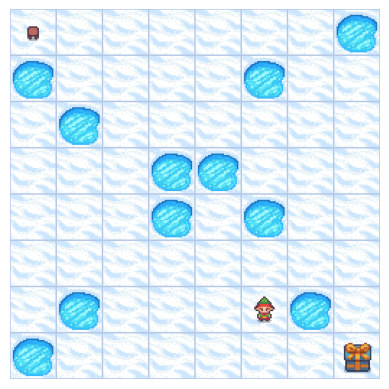

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np

# Lists to store runtimes and path lengths
bnb_times, bnb_lengths = [], []
astar_times, astar_lengths = [], []

# Run multiple times for averaging
for i in range(5):
    # Branch and Bound
    start_state, _ = environment.reset()
    goal_state = n_states - 1
    frames = []
    start = time.time()
    path_bnb = branch_and_bound(environment, start_state, goal_state)
    bnb_times.append(time.time() - start)
    bnb_lengths.append(len(path_bnb) if path_bnb else 0)

    # A*
    start_state, _ = environment.reset()
    goal_state = n_states - 1
    frames = []
    start = time.time()
    path_astar = a_star_search(environment, start_state, goal_state)
    astar_times.append(time.time() - start)
    astar_lengths.append(len(path_astar) if path_astar else 0)

# Averages
avg_bnb_time = np.mean(bnb_times)
avg_astar_time = np.mean(astar_times)
avg_bnb_length = np.mean(bnb_lengths)
avg_astar_length = np.mean(astar_lengths)

print(f"Avg Branch and Bound Time: {avg_bnb_time:.4f}s, Avg Path Length: {avg_bnb_length}")
print(f"Avg A* Time: {avg_astar_time:.4f}s, Avg Path Length: {avg_astar_length}")

# Plotting
labels = ['Branch and Bound', 'A* Search']
colors = ['orange', 'purple']

plt.figure(figsize=(10, 4))

# Runtime plot
plt.subplot(1, 2, 1)
plt.bar(labels, [avg_bnb_time, avg_astar_time], color=colors)
plt.ylabel("Avg Runtime (s)")
plt.title("Average Runtime Comparison")

# Path length plot
plt.subplot(1, 2, 2)
plt.bar(labels, [avg_bnb_length, avg_astar_length], color=colors)
plt.ylabel("Avg Path Length")
plt.title("Average Path Length Comparison")

plt.tight_layout()
plt.savefig("bnb_astar_runtime_comparison.png")
plt.show()


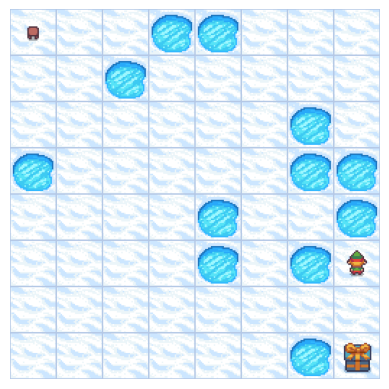

 Time taken (A*): 50.5635 seconds
 Saved line chart as 'runtime_comparison.png'


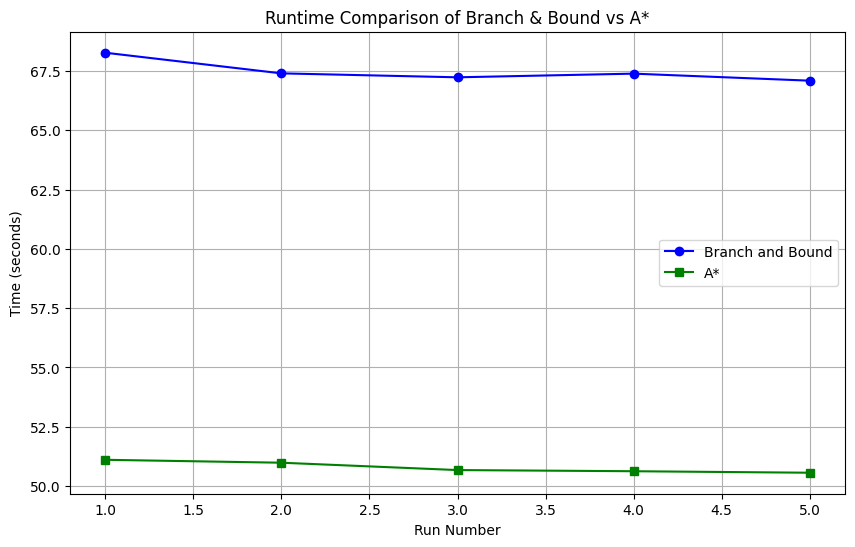

In [ ]:
import time
import matplotlib.pyplot as plt

# To store runtimes
bb_runtimes = []
astar_runtimes = []
run_numbers = list(range(1, 6))  # Run 5 times for each algorithm

# Benchmark Branch & Bound
for i in run_numbers:
    print(f"\n Run #{i} — Branch and Bound")

    environment.reset()
    start_state, _ = environment.reset()

    start_time = time.time()
    path = branch_and_bound(environment, start_state, goal_state)
    end_time = time.time()
    bb_runtimes.append(end_time - start_time)

    print(f" Time taken (Branch & Bound): {end_time - start_time:.4f} seconds")

# Benchmark A*
for i in run_numbers:
    print(f"\n Run #{i} — A*")

    environment.reset()
    start_state, _ = environment.reset()

    start_time = time.time()
    path = a_star_search(environment, start_state, goal_state)
    end_time = time.time()
    astar_runtimes.append(end_time - start_time)

    print(f" Time taken (A*): {end_time - start_time:.4f} seconds")

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(run_numbers, bb_runtimes, marker='o', label='Branch and Bound', color='blue')
plt.plot(run_numbers, astar_runtimes, marker='s', label='A*', color='green')
plt.title("Runtime Comparison of Branch & Bound vs A*")
plt.xlabel("Run Number")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.legend()

# Save the plot as PNG
plt.savefig("runtime_comparison.png")
print(" Saved line chart as 'runtime_comparison.png'")

plt.show()
